In [46]:
# import all the necessary libraries
import os
import shutil
import sys
from operator import add
import itertools
import numpy as np
import networkx as nx
import collections
import random
from sklearn.metrics import recall_score
import time as time
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib as mpl

In [48]:
path = "/content/sample_data/YouTube.edgelist"

G = nx.read_edgelist(path, create_using= nx.Graph())

# number of nodes and edges
print("The total number of nodes in the graph is: " + str(len(G)))
print("The total number of edges in the graph is: " + str(G.number_of_edges()))
n = len(G)
c = 29

The total number of nodes in the graph is: 7675
The total number of edges in the graph is: 35622


In [49]:
def initialize_F_seed(G, n, c, filename):


  initial_community_array = []


  file1 = open(f'/content/sample_data/{filename}.txt', 'r') 
  Lines = file1.readlines() 
    
  count = 0
  for line in Lines: 
      initial_community_array.append(np.array([int(i) for i in line.strip().split(" ")]))
      count = count + 1

  file1.close()
  F = np.zeros((n,c))
  counter = 0

  # assign Fuc = 1 for given communities
  for community in initial_community_array:
    for node in community:
      F[node,counter] = 1.0
    counter += 1

  K = np.zeros(c)
  start = time.time()

  # loop over all nodes, assigning to the community the node's nearest neighbors that are locally minimum.
  for i in range(n):
    if i % 1000 == 0: # print the node number to see the progress
      print(i)
    for j in range(c):
      S = np.copy(initial_community_array[j])
      
      neighor_indices = [] 
      neighor_indices.append(i)
      for k in G.neighbors(str(i)):
        S = np.append(S,int(k))
        neighor_indices.append(int(k))
      
      SS = set([str(k) for k in S])

      # compute the condictance after adding a node and ite neighbors to community c
      K[j] = nx.conductance(G, SS)

    arg_min = np.argmin(K) # locally minimal community 

    #assign the node and all its neighbors the locally minimal community
    F[neighor_indices,arg_min] = 1.0 

  print('time = ', time.time() - start)

  # save the matrix F
  np.savez(f'/content/sample_data/F_{filename}.npz', F = F)

  return F

def initialize_F_random(n, c):
 
  F = np.zeros((n,c))

  for i in range(n):
    r1 = random.randint(1,5)
    for j in range(r1):
      r2 = random.randint(0,28)
      F[i,r2] = 1.0

  # save the matrix F
  np.savez(f'/content/sample_data/F_random.npz', F = F)

  return F

filename = '20percent_seed_communities'
F_true_seed = initialize_F_seed(G, n, c, filename)

filename = 'neighborhood_seeds'
F_neighbor_seed = initialize_F_seed(G, n, c, filename)

F_random = initialize_F_random(n,c)

0
1000
2000
3000
4000
5000
6000
7000
time =  2077.5019776821136
0
1000
2000
3000
4000
5000
6000
7000
time =  2160.6805460453033


In [51]:

# loading the saved matrix
data = np.load('/content/sample_data/F_20percent_seed_communities.npz')
F_true_seed = data['F']
data = np.load('/content/sample_data/F_neighborhood_seeds.npz')
F_neighbor_seed = data['F']
data = np.load('/content/sample_data/F_random.npz')
F_random = data['F']

In [52]:
print('20 percent seed initilization : ', np.sum(F_true_seed))
print('Neighbor seed initilization : ', np.sum(F_neighbor_seed))
print('Random initilization : ', np.sum(F_random))

20 percent seed initilization :  18666.0
Neighbor seed initilization :  14861.0
Random initilization :  21786.0


In [53]:
def optimize_matrix(G,F,n,c,n_iters,lr):

  update_value = np.zeros(n_iters)
  
  for k in range(n_iters):
    # compute the sum of all nodes
    initial_sum = np.sum(F,axis=0)

    # iterate for each row of the column F
    for i in range(n):
      fu = np.copy(F[i,:])
      first_term = np.zeros(c)
      neighours_sum = np.zeros(c)

      # iterate over all neighbors of node u
      for j in G.neighbors(str(i)):
        int_j = int(j)
        fv = np.copy(F[int_j,:])

        product = np.sum(fu*fv) 

        if product == 0:
          first_term = first_term + fv*0.0
        else:
          first_term = first_term + fv*(np.exp(-product)/(1.0 - np.exp(-product)))
        neighours_sum = neighours_sum + fv
      
      second_term = initial_sum - fu - neighours_sum

      # gradient computation
      gradient = first_term - second_term
      fold = np.copy(F[i,:])

      # update ith row of F
      F[i,:] = F[i,:] + lr*gradient      
      F[i,:] = np.where(F[i,:]<0, 0.00001, F[i,:])

      # store the maximum value of change in F amongst all nodes
      if np.linalg.norm(fold - F[i,:]) > update_value[k]:
        update_value[k] = np.linalg.norm(fold - F[i,:])

    if k%50 == 0:
      print(k, update_value[k])

  return F, update_value

In [54]:
n_iters = 400
lr = 0.0001
F_true_seed_optimized, update_value_true_seed = optimize_matrix(G,F_true_seed,n,c,n_iters,lr)

0 0.6921014583493202
50 0.023160492447236104
100 0.015617903361251795
150 0.01251555882360773
200 0.010703803791800652
250 0.009902020402237607
300 0.009200120568299927
350 0.007932267392996047


In [55]:
n_iters = 400
lr = 0.0001
F_neighbor_seed_optimized, update_value_neighbor_seed = optimize_matrix(G,F_neighbor_seed,n,c,n_iters,lr)

0 0.8313079312206066
50 47.382792887333366
100 94.43799554803009
150 94.68686630405186
200 16.763779291458295
250 32.85882954037308
300 30.319806770592425
350 22.242097688532095


In [56]:
n_iters = 400
lr = 0.0001
F_random_optimized, update_value_random = optimize_matrix(G,F_random,n,c,n_iters,lr)

0 551600.2946932369
50 425.3927555295337
100 990.5714481933251
150 510.886544625673
200 602.9652829640836
250 295.39606555481765
300 431.7625541719832
350 468.2383551719252


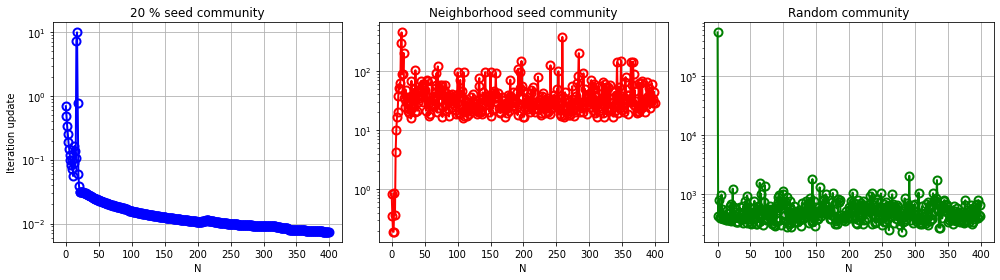

In [61]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
axs = ax.flat
axs[0].semilogy(update_value_true_seed, 'bo-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')
axs[1].semilogy(update_value_neighbor_seed, 'ro-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')
axs[2].semilogy(update_value_random, 'go-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')
for i in range(3):
  axs[i].grid()
  axs[i].set_xlabel('N')
  if i == 0:
    axs[i].set_ylabel('Iteration update')

axs[0].set_title('20 % seed community')
axs[1].set_title('Neighborhood seed community')
axs[2].set_title('Random community')
fig.tight_layout()
plt.show()

In [62]:
epsilon = 1.0e-8
delta = np.sqrt(-np.log(1.0 - epsilon))
print(delta)

0.00010000000050123797


In [63]:
ground_truth_community_array = []
file1 = open('/content/sample_data/groundtruth_communities.txt', 'r') 
Lines = file1.readlines() 
  
count = 0
for line in Lines: 
    ground_truth_community_array.append(np.array([int(i) for i in line.strip().split(" ")]))
    count = count + 1

file1.close()

y_true = np.zeros((n,c))
counter = 0
for community in ground_truth_community_array:
  for node in community:
    y_true[node, counter] = 1.0
  counter = counter + 1

In [64]:
y_pred_true_seed = np.zeros((n,c))
y_pred_neighbor_seed = np.zeros((n,c))
y_pred_random = np.zeros((n,c))

for i in range(n):
  pred_community = np.where(F_true_seed_optimized[i,:] > delta)
  for j in pred_community[0]:
    y_pred_true_seed[i,j] = 1.0

  pred_community = np.where(F_neighbor_seed[i,:] > delta)
  for j in pred_community[0]:
    y_pred_neighbor_seed[i,j] = 1.0
  
  pred_community = np.where(F_random[i,:] > delta)
  for j in pred_community[0]:
    y_pred_random[i,j] = 1.0

In [65]:
# communities predicted for 20% initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_true_seed[i,j] == 1.0:
      item.append(i)
  my_list.append(item)


with open('/content/sample_data/predicted_community_20percent_seed.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [66]:
# write predicted communities for neighborhood initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_neighbor_seed[i,j] == 1.0:
      item.append(i)
  my_list.append(item)

# change this path
with open('/content/sample_data/predicted_community_neighbor_seed.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [67]:
#communities which are predicted for random initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_random[i,j] == 1.0:
      item.append(i)
  my_list.append(item)


with open('/content/sample_data/predicted_community_random.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [68]:
recall_true_seed = 0.0

ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_true_seed[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_true_seed = recall_true_seed + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_true_seed = recall_true_seed/c

In [69]:
recall_neighbor_seed = 0.0
ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_neighbor_seed[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_neighbor_seed = recall_neighbor_seed + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_neighbor_seed = recall_neighbor_seed/c

In [70]:
recall_random = 0.0
ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_random[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_random = recall_random + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_random = recall_random/c

In [71]:
print('20 % seed community: ', np.round(recall_true_seed, 4))
print('Neighborhood seed community: ', np.round(recall_neighbor_seed, 4))
print('Random community : ', np.round(recall_random, 4))

20 % seed community:  0.8593
Neighborhood seed community:  0.5262
Random community :  0.167


When 20 percent of the nodes from the ground truth are used to initiate F, the recall is roughly 0.86. 

The recall of random initilization is roughly 0.19.

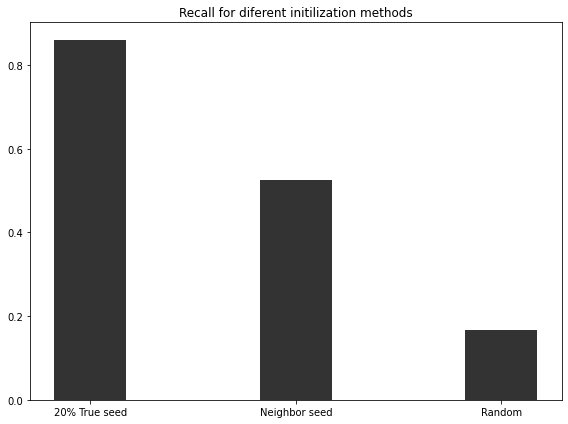

In [72]:
data = {'20% True seed': recall_true_seed, 'Neighbor seed': recall_neighbor_seed, 'Random': recall_random}
names = list(data.keys())
values = list(data.values())

x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axs.bar(names, values, width, color='k', alpha=0.8)
plt.title('Recall for diferent initilization methods')

fig.tight_layout()
plt.show()

In [73]:
from numpy import load
data = load('/content/sample_data/F_random.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

F
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [74]:
from numpy import load
data = load('/content/sample_data/F_neighborhood_seeds.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

F
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
from numpy import load
data = load('/content/sample_data/F_20percent_seed_communities.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

F
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]]
